[120]Magna Graecia\
Sergio Enrico Pisoni 132855\
Sofia Papaioannou 132898\
Lefteris Verouchis 132873

In [13]:
from IPython.display import Image, display

# REPORT

## Exploratory data Analysis

Search domain knowledge

Check if the data is intuitive


Understand how the data was generated

Explore individual features

Explore pairs and groups of features

Clean up features

## Models experimentation

### RANDOM FOREST

As part of our initial experiments, we considered using Random Forest for both latitude and longitude prediction. Random Forest is a robust ensemble learning method that often performs well for regression tasks. 

We set the number of trees to be 20 with maximum depth dor each tree to be 25 for lattitude and 35 for lontitude, since we wanted to capture complex relationships in the data but not have the fear of overfitting. 

After training the models, we evaluated their performance using the Mean Absolute Error (MAE) metric. While Random Forest yielded reasonable results for first try and without compliting all the feature engineering that we added in the process, we observed that training times were relatively slow, especially with the large dataset and higher number of trees used in the ensemble.

So despite the effectiveness of Random Forest, we decided to explore XGBOOST due to lower training time.

In [14]:
# Train Random Forest model for latitude prediction
model_lat = RandomForestRegressor(n_estimators=20, max_depth=25, random_state=42, verbose=3)
model_lat.fit(X_train_lat, y_train_lat)

# Train Random Forest model for longitude prediction
model_lon = RandomForestRegressor(n_estimators=20, max_depth=35, random_state=42, verbose=3)
model_lon.fit(X_train_lon, y_train_lon)


NameError: name 'RandomForestRegressor' is not defined

### XGBOOST

Our final choice resided in XGbBoost due to its outstanding performance and relatively low training time.\
XGBoost is known for its ability to deliver high-quality predictions, especially when dealing with large, noisy datasets and a variety of features.\
Furthermore, XGBoost excels in handling missing data, feature interactions, and non-linear relationships, which makes it particularly well-suited for our dataset.\


## Feature Engineering


Feature engineering is a critical step in preparing data for meaningful analysis and predictive modeling, especially when dealing with complex datasets like AIS (Automatic Identification System). AIS data records extensive information on vessel locations, speeds, directions, navigational statuses,schedules and ports characteristics but it also comes with inherent challenges such as placeholder values, outliers, and inconsistent formats.

In this project, we used feature engineering to transform raw AIS and port data into a more accurate, comprehensive dataset. The goal was to enhance the quality and relevance of the data by refining existing features and creating new ones, making the information more suitable for understanding vessel behaviors, predicting arrival times, and optimizing routes and get more accurate predictions. By addressing missing values, aligning timestamps, and creating meaningful flags and derived features, we tried to take advantage from the most useful attributes.

In this section we document the specific steps taken, the rationale behind each transformation,in order to succeed it.

### Feature selection

-> Cleaning Ports Data: To streamline analysis, we removed unnecessary columns from the ports data, such as name, portLocation, UN_LOCODE, countryName, and ISO. We kept only the attributes that we considered essential and were important to give in order to train our model and get better results (portId, latitude, longitude). This reduced data size and minimized potential redundancies.
<br>-> Renaming Columns: We renamed latitude and longitude in the ports dataset to port_latitude and port_longitude. This renaming prevented confusion with vessel latitude and longitude values, making the dataset more intuitive and easier to work with.


In [ ]:
ports = pd.read_csv('ports.csv', sep ='|')
# Clean port data
ports = ports.drop(columns=['name', 'portLocation', 'UN_LOCODE', 'countryName', 'ISO'], errors='ignore')
# Rename latitude and longitude to distinguish them
ports = ports.rename(columns={
    'latitude': 'port_latitude',
    'longitude': 'port_longitude'
})

### Feature Preprocessing 

Handling default values, outliers, and missing data was essential for improving data consistency and accuracy.
<br><br>
Replacing Default and Outlier Values: AIS data uses certain default values to indicate unavailable or invalid measurements. For example, cog (course over ground) values are defaulted to 360 when not available. We replaced these default values with NaN, which allowed the model to ignore invalid values rather than treating them as valid data points but without any useful meaning.
<br>For cog: Replaced 360 with NaN and removed values above 360.
<br>For sog (speed over ground): Replaced 1023 with NaN, as this default represents unavailable data.
<br>For rot (rate of turn): Replaced 128 with NaN, indicating missing values. Additionally, values of +127 and -127 signify an uncertain rate of turn. We replaced these values with extreme values (200 and -200, respectively) and added an uncertain_rot flag to mark these rows.
<br>For heading: Replaced 511 with NaN, which indicates an unavailable heading measurement.
This preprocessing step ensures that only valid valued are being taken into account, and helps our model to perform better without biased values.

<br>Adding Flags: we added an uncertain_rot flag to identify rows where rot values were uncertain (200 or -200). Additionally, we created an isMoored flag to denote when vessels were moored, derived from the navstat variable (navstat = 5 indicates a moored vessel). This feature helped identify vessels that were stationary, which could influence movement-based analyses.

In [ ]:
def preprocess(df):
    # Replacing default with Nan bacause too close to valid values, eliminate non valid values
    df['cog'] = df['cog'].replace(360, np.nan)
    df = df[(df['cog'] <= 360) | (df['cog'].isna())]

    # Replacing default with Nan bacause too close to valid values
    df['sog'] = df['sog'].replace(1023, np.nan)

    # Replacing default with Nan bacause too close to valid values
    # Changing uncertain values to bigger number to be further away from sample pool
    # Adding uncertainty flag
    df['rot'] = df['rot'].replace(128, np.nan)
    df['rot'] = df['rot'].replace({127: 200, -127: -200})
    df['uncertain_rot'] = np.where(df['rot'].isin([200, -200]), 1, 0)

    # Replacing default value with NaN to not get taken in consideration by regression
    df['heading'] = df['heading'].replace(511, np.nan)

    # Adding a "is moored?" flag
    df['isMoored'] = (df['navstat'] == 5).astype(int)   

    # Time Handling 
    df['time'] = pd.to_datetime(df['time'], errors='coerce').dt.tz_localize('UTC')
    # Standardize eta
    df['etaRaw'] = df['etaRaw'].fillna(0)
    df['etaRaw'] = df['etaRaw'].apply(lambda x: f"{2024}-{x}")
    df['etaRaw'] = pd.to_datetime(df['etaRaw'], errors='coerce').dt.tz_localize('UTC')
    df.rename(columns={'etaRaw': 'etaStd'}, inplace=True)
    # Handle first month of the years ETA year to be 2023
    df['etaStd'] = df.apply(lambda row: row['etaStd'].replace(year=row['etaStd'].year - 1)
                            if row['etaStd'].month in [11, 12] and row['time'].month in [1, 2] 
                            else row['etaStd'], axis=1) 

    # FEATURE ENGINEERING
    # Get day of the week 
    df['dayofweek'] = df['time'].dt.dayofweek
    df['eta_dayoftheweek'] = df['etaStd'].dt.dayofweek 
    # Converts time and eta to seconds and add difference between the two
    df['time_seq'] = df['time'].astype(int) / 10**9  
    df['eta_seq'] = df['etaStd'].astype(int) / 10**9 
    df['estimated_time_left'] = df['time_seq'] - df['eta_seq']
    # Add port coordinates
    df = pd.merge(df, ports, on='portId', how='left')
    # Add a three days rolling average for the AIS data 
    df['sog_mean'] = df.groupby('vesselId', group_keys=False).apply(
    lambda x: x.sort_values('time').rolling('3D', on='time')['sog'].mean())
    df['cog_mean'] = df.groupby('vesselId', group_keys=False).apply(
    lambda x: x.sort_values('time').rolling('3D', on='time')['cog'].mean())
    df['rot_mean'] = df.groupby('vesselId', group_keys=False).apply(
    lambda x: x.sort_values('time').rolling('3D', on='time')['rot'].mean())
    df['heading_mean'] = df.groupby('vesselId', group_keys=False).apply(
    lambda x: x.sort_values('time').rolling('3D', on='time')['heading'].mean())
    
    return df

#### Timestamp Handling and Date Features
Time and ETA Standardization: Both time and etaRaw columns were converted to standardized datetime formats, in order to make more accurate time-based calculations.

time was converted to a timezone-aware UTC datetime.

etaRaw was standardized to etaStd, with missing values filled as 0. The format was modified to incorporate the current year (2024-) for ease of handling.
<br>Adjusting ETA Across Years: For vessels scheduled to arrive early in the year (January or February) but reporting etaRaw in November or December, we adjusted the year of etaStd to the previous year (2023). This adjustment avoided errors in estimated time calculations by aligning cross-year arrivals with correct temporal references.

Creating Derived Time Features: To capture weekly trends in vessel activity, we created two new features, dayofweek and eta_dayoftheweek, representing the weekday for both the time and etaStd columns. This step allowed us to capture weekly patterns that may influence vessel schedules and movement behaviors.

Converting Time to Seconds and Calculating Differences: The time and etaStd columns were converted to Unix timestamps (time_seq and eta_seq), representing the seconds since the Unix epoch. We then computed estimated_time_left as the difference between these two features, representing the remaining time for a vessel to reach its destination.
This feature, estimated_time_left, provides an estimated arrival time which is useful for making predictions. 

Merging Port Coordinates: The next step was to add port coordinates to the AIS dataset. I merged the AIS dataset with ports data on the portId column, using a left join to ensure that each vessel’s record retained the port’s latitude and longitude (port_latitude, port_longitude).
Including port location data is essential for geospatial analysis, providing context for vessel proximity to ports and supporting models that incorporate spatial features.

To smooth out short-term fluctuations and capture broader trends, we applied a 3-day rolling average to key navigation variables: sog (speed over ground), cog (course over ground), rot (rate of turn), and heading. These rolling averages were computed individually for each vessel by grouping data by vesselId and sorting by time.
For instance, sog_mean represents the average speed of a vessel over a 3-day window. By doing this, we create a more stable trend for each vessel's movement over time, making easier for our model to learn and predict consistent behaviors.

## Model Interpretation
While XGBoost's core algorithm is conceptually straightforward, its behavior becomes increasingly complex when trained on sophisticated datasets, approaching what we might consider a 'black box' model. To enhance model transparency, we leverage two key analysis techniques: feature importance metrics and SHAP waterfall plots.
### Feature importance
Feature importance analysis provides crucial insights into the model's decision-making process, offering valuable guidance for subsequent model development. The F-score metric quantifies each feature's impact by measuring how frequently it appears as a decision node across the model's trees: higher F-scores indicate features that play more pivotal roles in the model's predictions.

Let's examine our model's feature importance results:

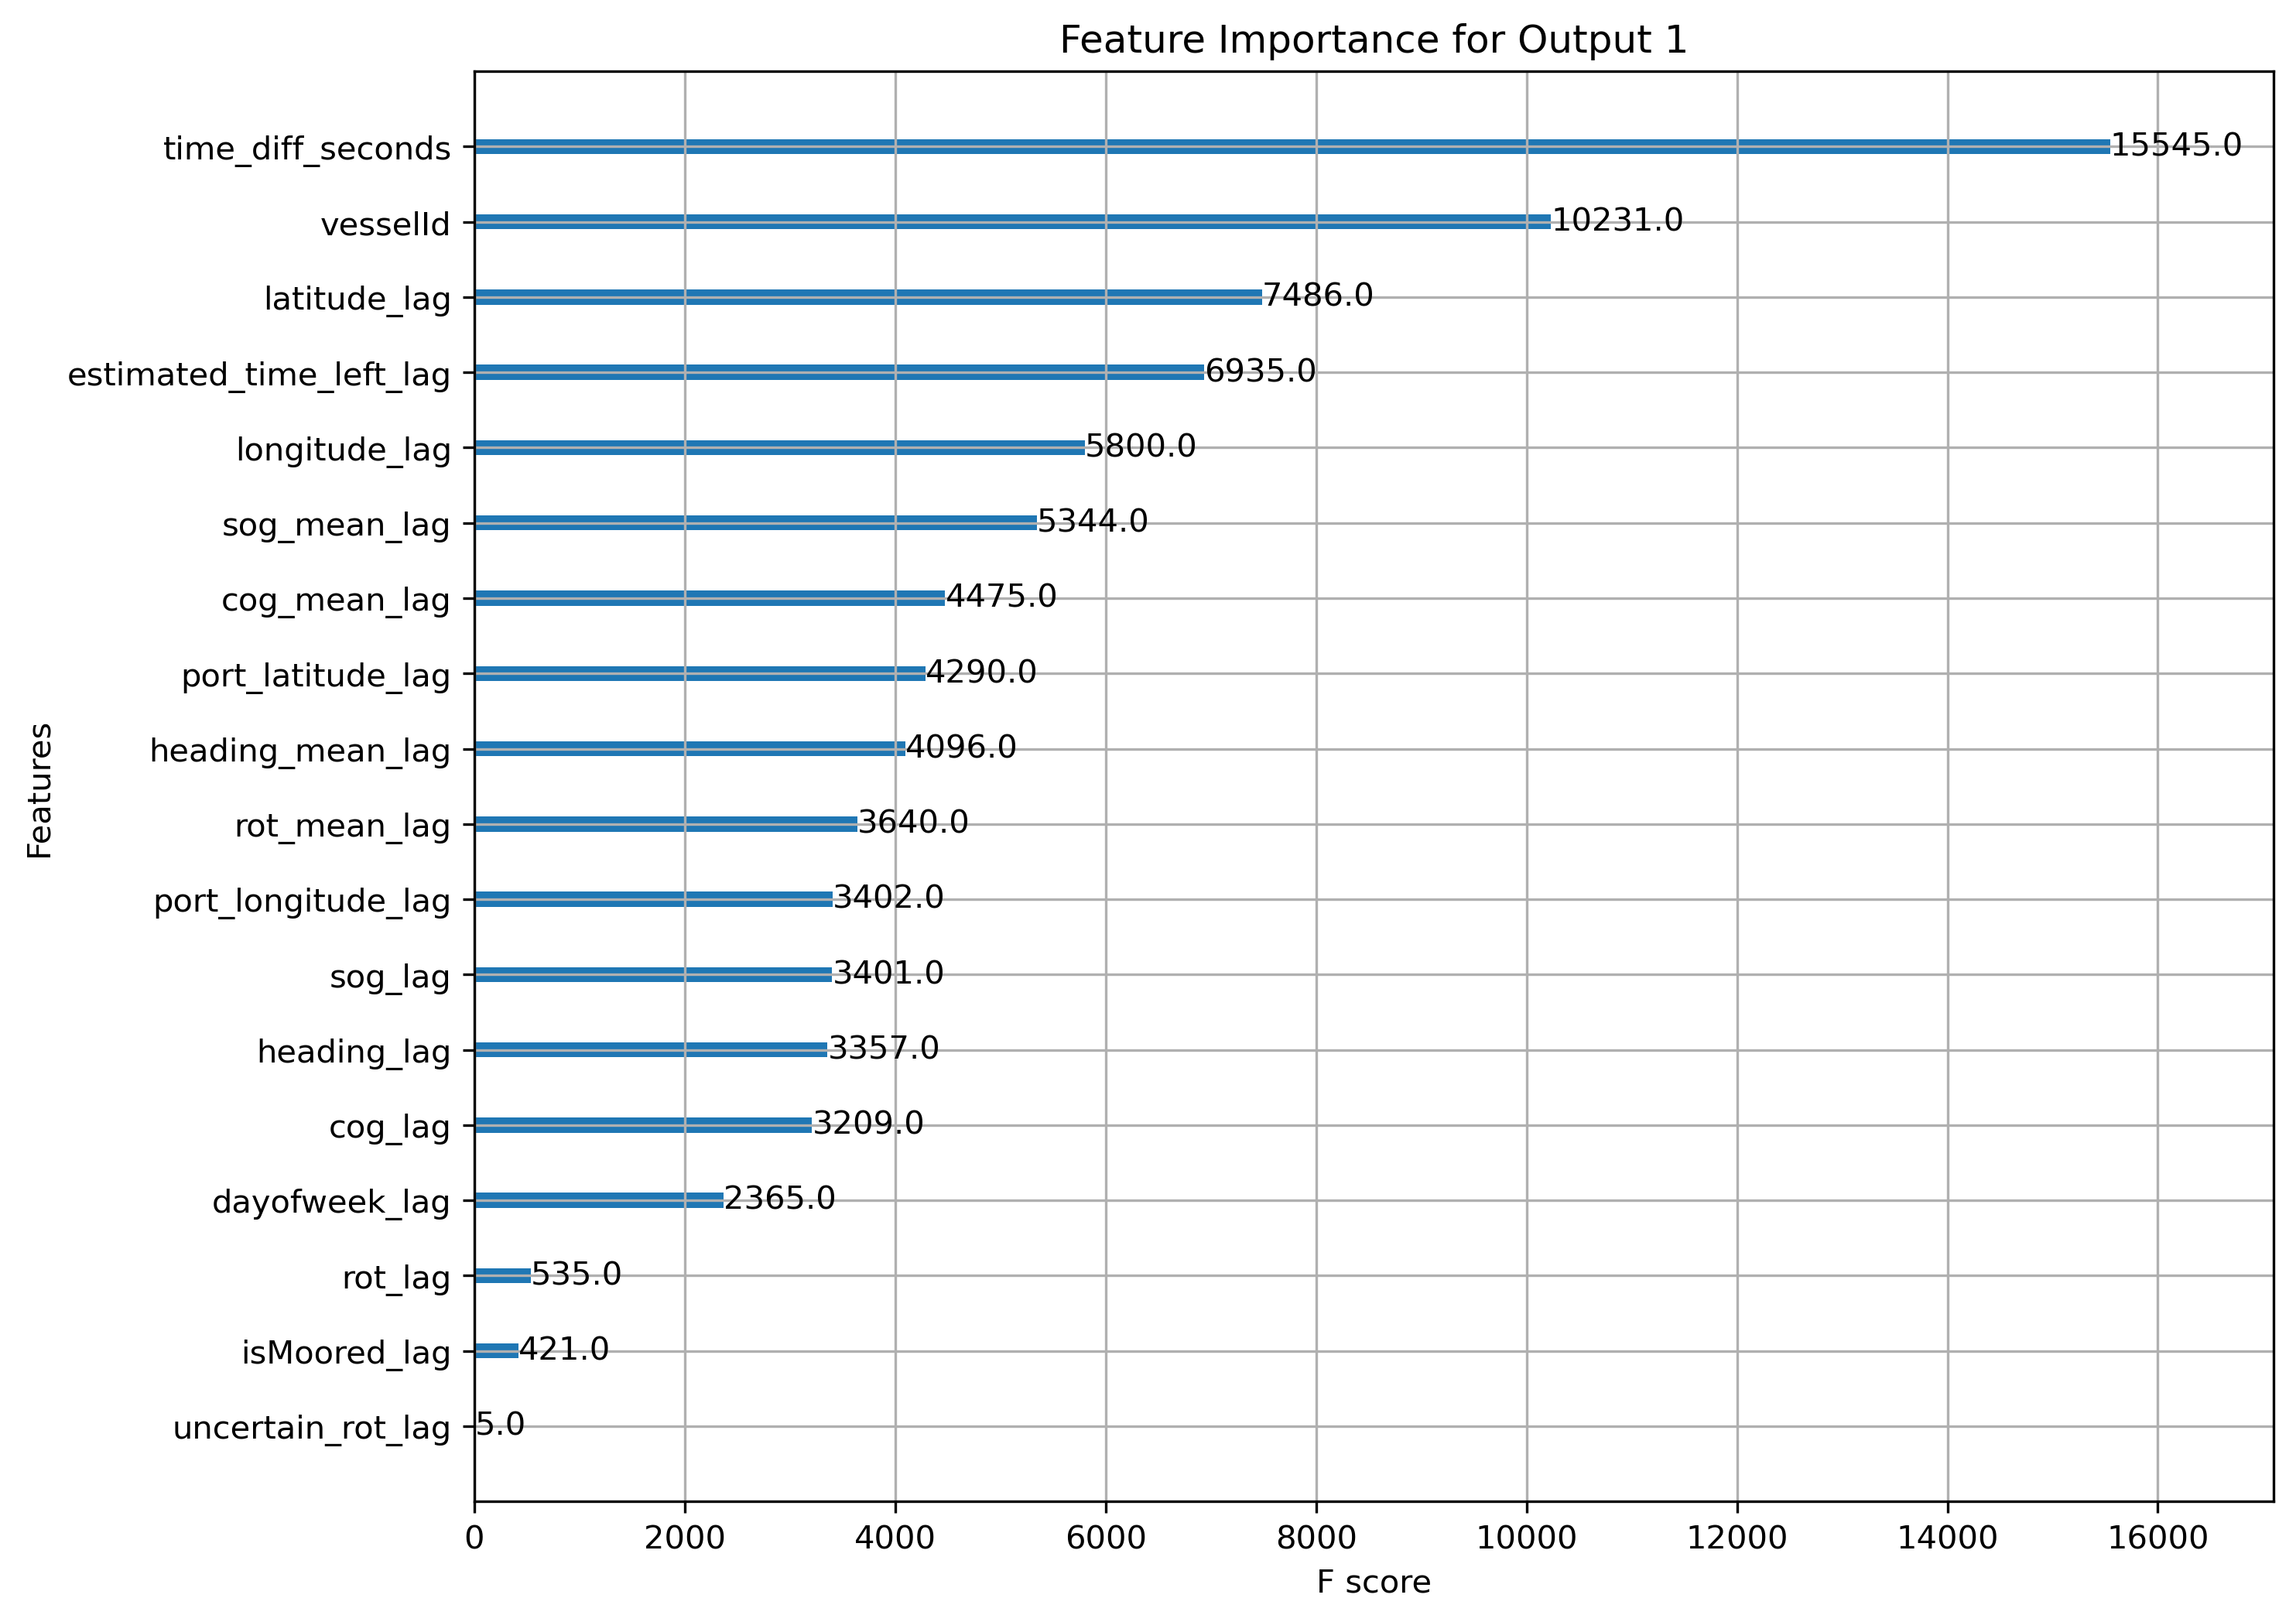

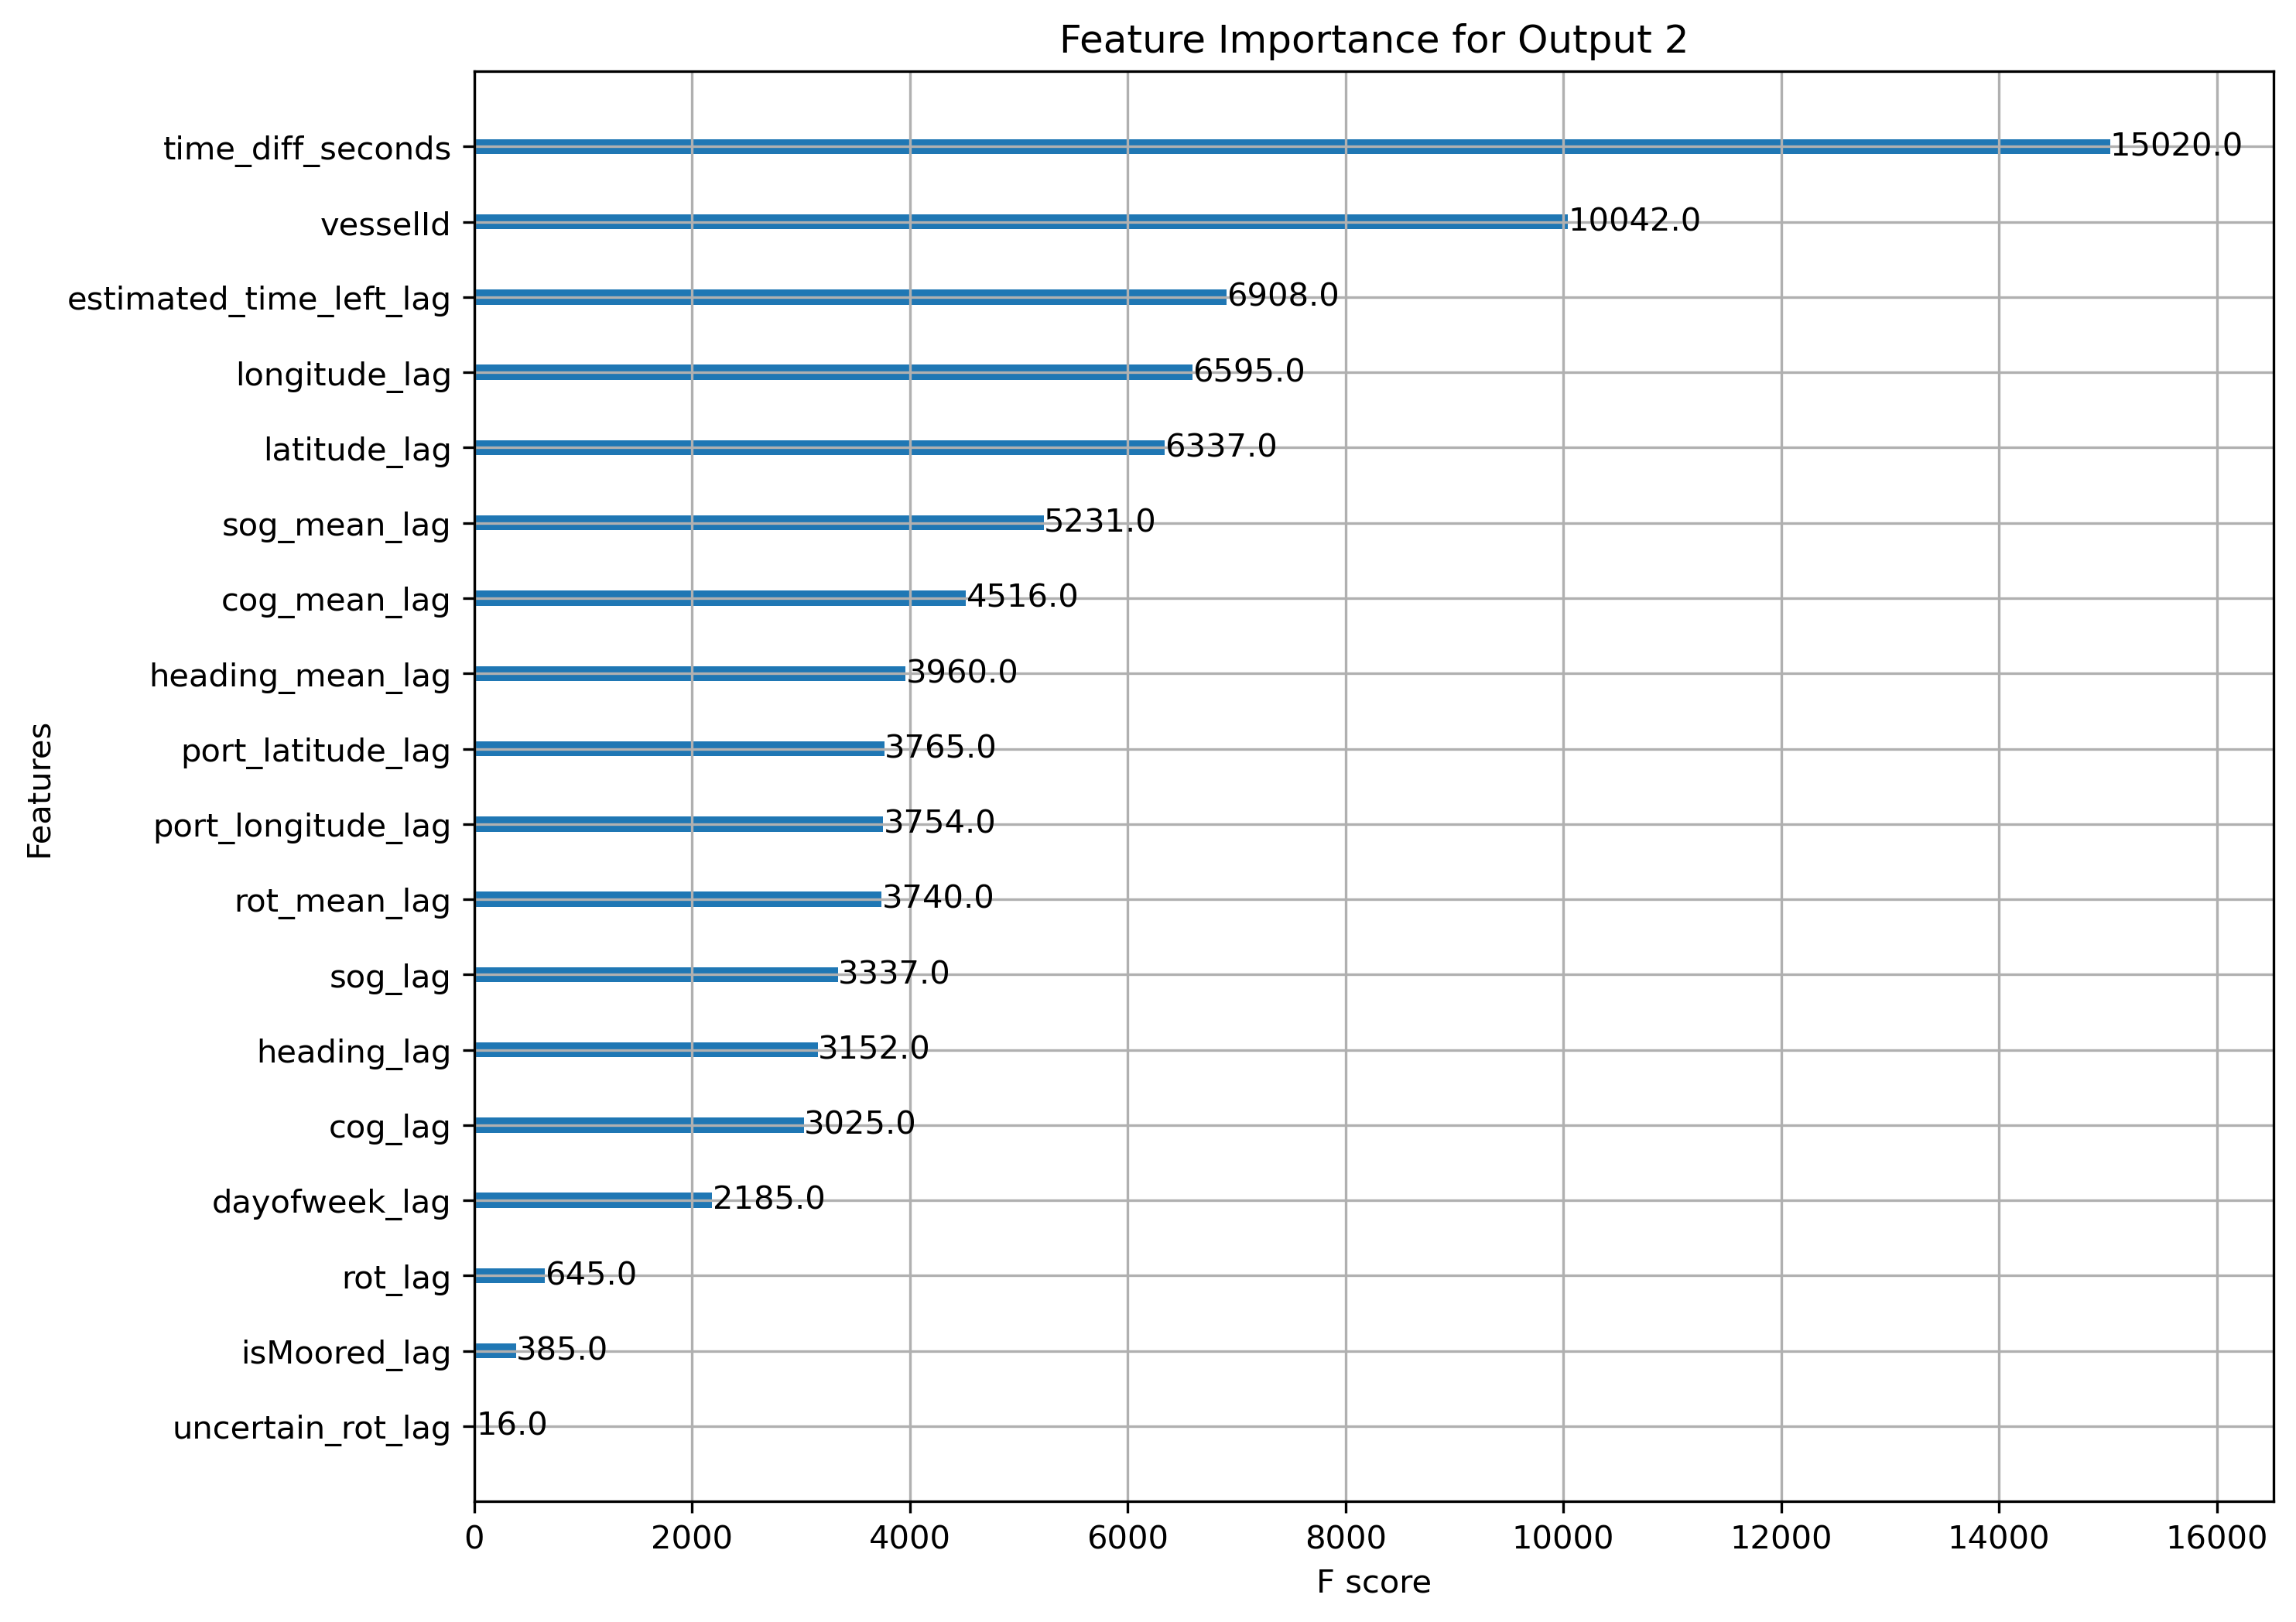

In [22]:
display(Image(filename='plots/feature_importance_output_1.png'), Image(filename='plots/feature_importance_output_2.png'))

These plots demonstrate the effectiveness of our feature engineering approach. The engineered features - particularly port coordinates, time to ETA, and rolling means - emerge as the key drivers of model differentiation.

A crucial insight came from our multi-horizon training strategy: the time_diff feature proved to be the most influential predictor for coordinate estimation. This validates our decision to create multiple training sets across different time horizons.

Conversely, the binary flags (isMoored and uncertain_rot) showed minimal impact on model decisions. This finding provides valuable guidance for future feature engineering: when combining binary flags with more sophisticated numerical features, their relative importance may be significantly diminished.

Let's examine these features in action through visualizations of randomly sampled instances from our training set (X_train).

### SHAP waterfall plots
SHAP (SHapley Additive exPlanations) provides us with an intuitive geometric interpretation of our model's decision-making process.

For regression models like ours, SHAP plots visualize how each feature contributes to pushing predictions away from the baseline (mean) value. Each feature's contribution is displayed as either a positive or negative force, collectively explaining how the model arrives at its final prediction.

Let's examine some illustrative examples below:

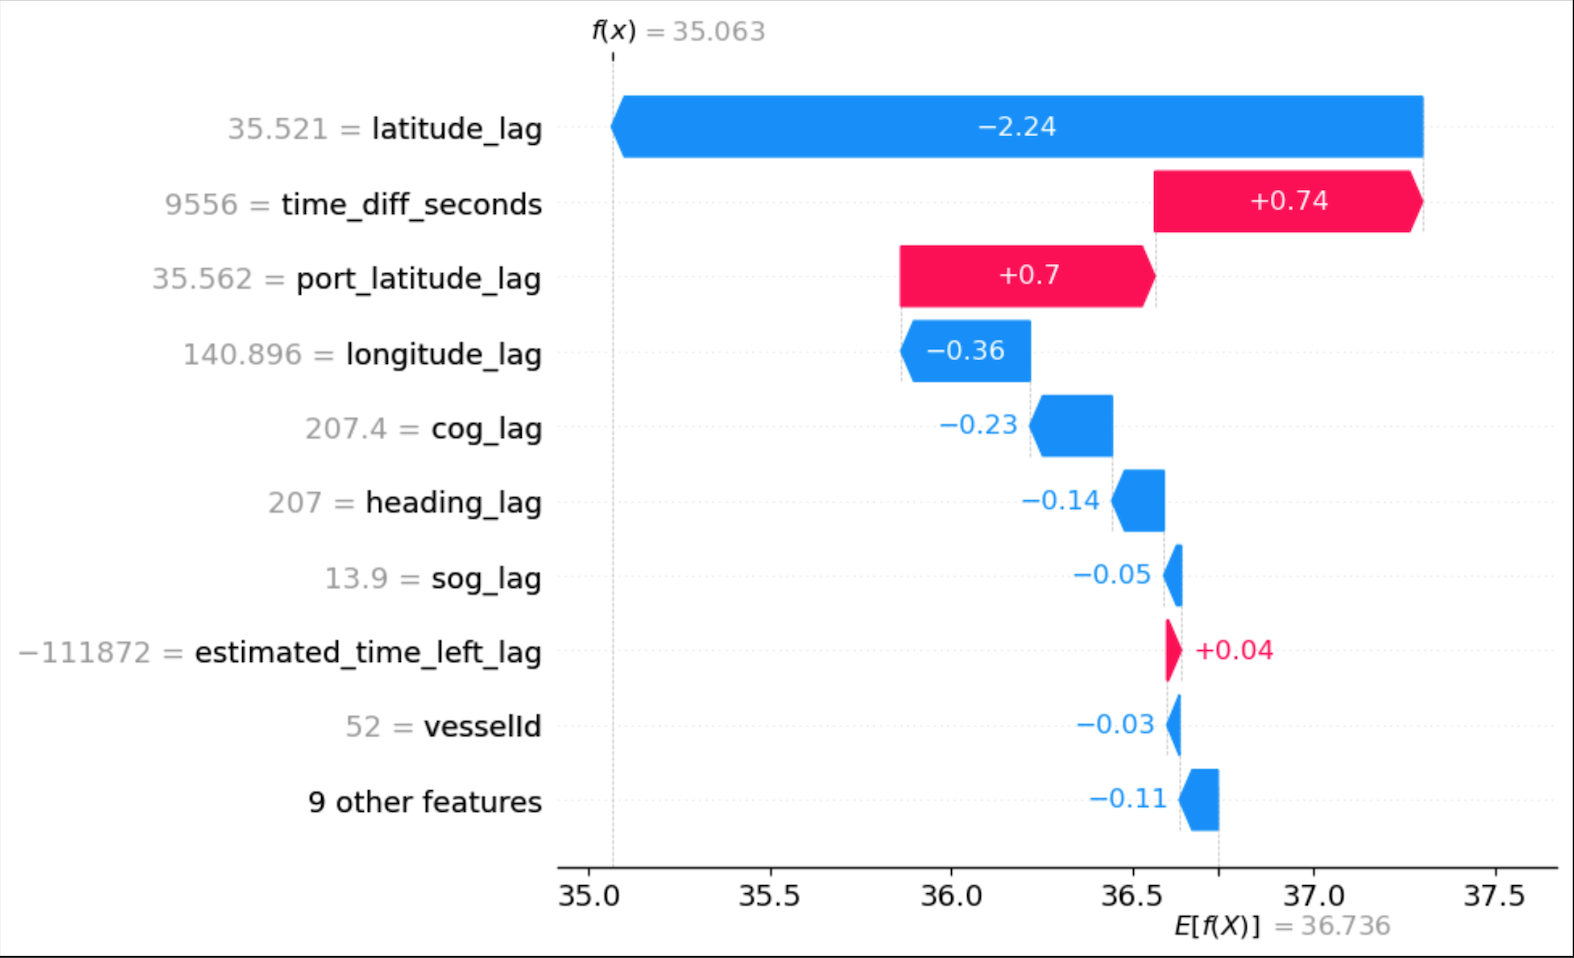

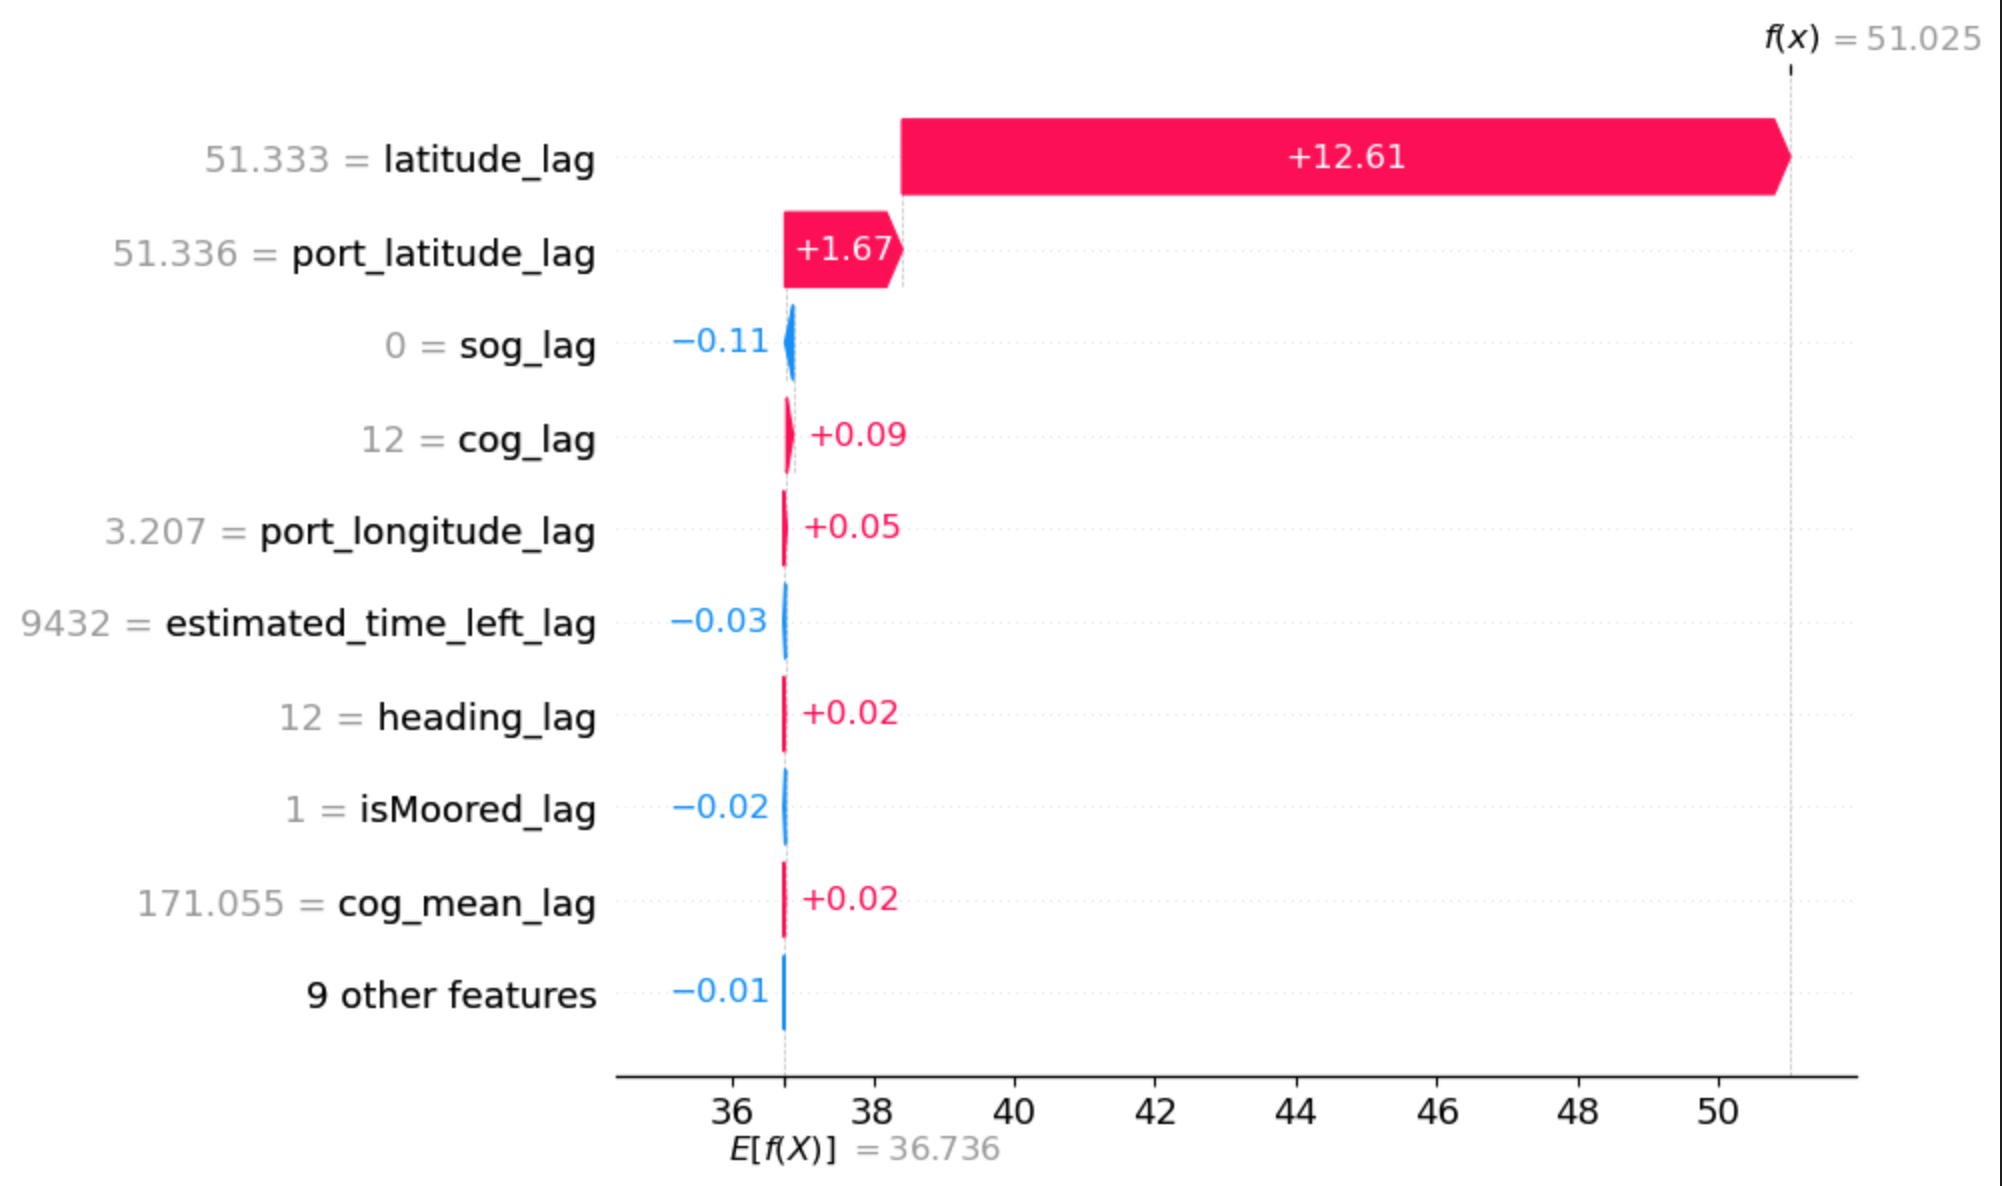

In [24]:
display(Image(filename='plots/shap_1.png'), Image(filename='plots/shap_2.png'))

The feature importance plots provide clear insights into which variables most significantly influence the predictions for individual instances.

Through random sampling analysis, we confirmed that the features with the highest F-scores consistently produced the largest impacts on predictions. However, due to the high variance in both latitude and longitude, we frequently observed a distinct pattern, as illustrated in the second plot. In these cases, the model's predictions followed a two-phase pattern: initial small adjustments based on the vessel's recent behavior, followed by more substantial corrections when the vessel's position deviated significantly from the mean trajectory.

This pattern suggests that the model effectively balances immediate vessel dynamics with broader geographical constraints.

These interpretation tools not only validate our current approach but also provide clear directions for future projects. Understanding which features drive our model's decisions enables us to focus future development efforts on enhancing the most influential variables while potentially simplifying our feature set by removing less impactful ones.